# Solving the 2D Laplace Equation using Finite Differences

In this notebook, we will solve the steady-state 2D Laplace equation on a square domain using the **finite difference method (FDM)**.  
We will compare different numerical solvers: **Jacobi, Gauss-Seidel, and SOR**.  

The Laplace equation in 2D is:

$
\nabla^2 T = 0
$

with given boundary conditions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve, gmres
from time import time


## 1. Grid Setup and Boundary Conditions

We discretise a square domain of size  $L \times L$ with a uniform grid.  
- `N`: number of interior points per direction
- `L`: Length of the domain  
- `h`: grid spacing
- 
- Boundary conditions are set as fixed temperatures at each edge.


In [2]:
# Grid and physical parameters
N = 25                 
L = 1.0                 
h = L / (N + 1)         

# Boundary conditions
T_top    = 10
T_bottom = 0
T_left   = 10
T_right  = 10

# Initialise full grid including boundaries (size (N+2)x(N+2))
T_full = np.zeros((N + 2, N + 2))
T_full[0, :] = T_top
T_full[-1, :] = T_bottom
T_full[:, 0] = T_left
T_full[:, -1] = T_right


## 2. Finite Difference Discretisation of the Laplace Equation

#### The Continuous Laplace Equation

The Laplace equation in 2D is:

$
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0
$

This describes steady-state heat conduction in a domain with no heat sources.

---

#### Finite Difference Discretisation

We approximate the second derivatives using a combination of **forward and backward differences**:

$
\frac{\partial^2 T}{\partial x^2} \approx \frac{T_{i,j-1} - 2T_{i,j} + T_{i,j+1}}{h^2}
$
$
\frac{\partial^2 T}{\partial y^2} \approx \frac{T_{i-1,j} - 2T_{i,j} + T_{i+1,j}}{h^2}
$

Substituting into the Laplace equation:

$
\frac{T_{i,j-1} - 2T_{i,j} + T_{i,j+1}}{h^2} + \frac{T_{i-1,j} - 2T_{i,j} + T_{i+1,j}}{h^2} = 0
$

Multiply both sides by $ h^2 $:

$
T_{i,j-1} + T_{i,j+1} + T_{i-1,j} + T_{i+1,j} - 4T_{i,j} = 0
$

This is the famous **5-point stencil** for the Laplace equation.

---

#### Building the Matrix A

The discretized equation for each interior point $(i,j)$ becomes:

$
-4T_{i,j} + T_{i,j-1} + T_{i,j+1} + T_{i-1,j} + T_{i+1,j} = 0
$

We need to express this as a matrix equation $ A\mathbf{T} = \mathbf{b} $, where:
- $ \mathbf{T} $ is a vector of all unknown temperatures
- $ A $ encodes the finite difference stencil
- $ \mathbf{b} $ contains boundary condition contributions

---

#### Index Mapping: 2D → 1D

Since we're working with matrices (2D arrays), we need to flatten our 2D grid to a 1D vector:

```python
def idx(i, j):
    return (i - 1) * N + (j - 1)


In [3]:
# Construct the 5-point Laplacian matrix A
A = np.zeros((N*N, N*N))

# Index mapping from 2D grid to 1D vector
def idx(i, j):
    return (i - 1) * N + (j - 1)
    
for i in range(1, N + 1):              # y-direction
    for j in range(1, N + 1):          # x-direction
        k = idx(i, j)                  # Convert 2D position to 1D index
        A[k, k] = -4                   # Center point coefficient
        if j < N: 
            A[k, idx(i, j + 1)] = 1    # Right neighbor
        if j > 1:
            A[k, idx(i, j - 1)] = 1    # Left neighbor
        if i < N:
            A[k, idx(i + 1, j)] = 1    # Bottom neighbor
        if i > 1:
            A[k, idx(i - 1, j)] = 1    # Top neighbor


### Constructing the Right Hand Side

We now build the right hand side vector b using the given boundary conditions.

For the Laplace equation $A\mathbf{T} = \mathbf{b}$, the vector $\mathbf{b}$ contains contributions from **boundary conditions**. Since the Laplace equation has no source terms, $\mathbf{b}$ is zero everywhere except where interior points neighbor the boundary.

In [4]:
# Right-hand side vector (zeros for Laplace)
b = np.ones(N * N)
b *= 00


# Adjust RHS vector for boundary contributions
for i in range(1, N + 1):
    for j in range(1, N + 1):
        k = idx(i, j)
        if i == 1:  # top neighbor
            b[k] -= T_full[i - 1, j]
        if i == N:  # bottom neighbor
            b[k] -= T_full[i + 1, j]
        if j == 1:  # left neighbor
            b[k] -= T_full[i, j - 1]
        if j == N:  # right neighbor
            b[k] -= T_full[i, j + 1]
b

array([-20., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., -10., -10.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10., -10.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       -10., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., -10., -10.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0., -10., -1

## 3. Iterative Solvers: Jacobi, Gauss-Seidel, and SOR

From lecture notes, the general iterative update formula is:

$
\phi^{n+1} = \phi^n + M^{-1}\,\rho(\phi^n),
$

where the residual is defined as:

$
\rho(\phi) = Q - A\phi.
$

Different solvers correspond to **different choices of the splitting matrix \(M\)**.


### 🔹 Jacobi Method

From the lecture notes:

$
\phi^{n+1} = \phi^n + D^{-1}\,\rho(\phi^n),
$

where \(D\) is the **diagonal part** of \(A\).

➡️ Interpretation:  
- Only the diagonal entries of \(A\) are inverted.  
- Each update uses values from the **previous iteration only**.  
- That is why the Jacobi method is simple but converges relatively slowly.

---

### 🔁 From Theoretical Form to Computational Form

We start with the residual definition:

$
\rho(\phi^n) = b - A\phi^n
$

Substitute into the Jacobi update:

$
\phi^{n+1} = \phi^n + D^{-1}(b - A\phi^n)
$

Now, split matrix \(A\) into its diagonal and off-diagonal parts:

$
A = D + R
$

where \(R\) contains all off-diagonal elements of \(A\) (with zeros on the diagonal).

Substitute this decomposition:

$
\phi^{n+1} = \phi^n + D^{-1}(b - (D + R)\phi^n)
$

Expand the parentheses:

$
\phi^{n+1} = \phi^n + D^{-1}b - D^{-1}D\phi^n - D^{-1}R\phi^n
$

Simplify using $(D^{-1}D = I)$:

$
\phi^{n+1} = \phi^n + D^{-1}b - \phi^n - D^{-1}R\phi^n
$

The $(\phi^n)$ terms cancel each other:

$
\phi^{n+1} = D^{-1}b - D^{-1}R\phi^n
$

Factor out $(D^{-1})$:

$
\phi^{n+1} = D^{-1}(b - R\phi^n)
$

---

### 💻 Final Computational Form

This leads to the efficient implementation:

```python
x_new = (b - R @ x_old) / D

In [5]:
def jacobi(A, b, tol=1e-6, max_iter=10000):
    x = np.zeros_like(b)
    D = np.diag(A)
    R = A - np.diagflat(D)
    residuals = []
    for k in range(max_iter):
        x_new = (b - R @ x) / D
        res = np.linalg.norm(A @ x_new - b)
        residuals.append(res)
        if res < tol:
            break
        x = x_new
    return x, residuals



### 🔹 Gauss-Seidel Method

From the slides:

$
\phi^{n+1} = \phi^n + E^{-1}\,\rho(\phi^n),
$

where \(E\) is the **lower triangular part** of \(A\).

➡️ Interpretation:  
- Updates are done **sequentially**, using the newest available values.  
- This corresponds to inverting a triangular system at each iteration.  
- Gauss-Seidel converges faster than Jacobi because information propagates more quickly.

---

### 🔁 From Theoretical Form to Computational Form

#### Step 1: Expand the Matrix Equation

$
\phi^{n+1} = \phi^n + E^{-1}(b - A\phi^n)
$

This suggests we need to compute $ E^{-1} $, which is **computationally expensive** (O(n³) operations).

---

#### Step 2: Avoid Explicit Matrix Inversion

Instead of computing $ E^{-1} $, we solve the equivalent system:

$
E \cdot \Delta\phi = \rho(\phi^n)
$

where $ \Delta\phi = \phi^{n+1} - \phi^n $ is the update vector.

This gives us:

$
E \cdot \Delta\phi = b - A\phi^n
$

---

#### Step 3: Write in Component Form

Since $E$ is lower triangular, we can solve this system using **forward substitution**. For each component $i$:

$
\sum_{j=1}^{i} E_{ij} \Delta\phi_j = b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n
$

Note that $( E_{ij} = A_{ij} )$ for $( j \leq i )$, and $( E_{ij} = 0 )$ for $( j > i )$.

---

#### Step 4: Expand and Rearrange

$
\sum_{j=1}^{i} A_{ij} \Delta\phi_j = b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n
$

Split the right-hand side:

$
\sum_{j=1}^{i} A_{ij} \Delta\phi_j = b_i - \sum_{j=1}^{i} A_{ij}\phi_j^n - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

---

#### Step 5: Express in Terms of New Values

Recall that $\Delta\phi_j = \phi_j^{n+1} - \phi_j^n $. Substitute:

$
\sum_{j=1}^{i} A_{ij} (\phi_j^{n+1} - \phi_j^n) = b_i - \sum_{j=1}^{i} A_{ij}\phi_j^n - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

Expand the left side:

$
\sum_{j=1}^{i} A_{ij}\phi_j^{n+1} - \sum_{j=1}^{i} A_{ij}\phi_j^n = b_i - \sum_{j=1}^{i} A_{ij}\phi_j^n - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

---

#### Step 6: Simplify the Equation

The terms $ -\sum_{j=1}^{i} A_{ij}\phi_j^n $ cancel on both sides:

$
\sum_{j=1}^{i} A_{ij}\phi_j^{n+1} = b_i - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

Now isolate $ \phi_i^{n+1} $ (the term where $ j = i $):

$
A_{ii}\phi_i^{n+1} + \sum_{j=1}^{i-1} A_{ij}\phi_j^{n+1} = b_i - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

---

#### Step 7: Final Component Form

$
A_{ii}\phi_i^{n+1} = b_i - \sum_{j=1}^{i-1} A_{ij}\phi_j^{n+1} - \sum_{j=i+1}^{n} A_{ij}\phi_j^n
$

Solve for $( \phi_i^{n+1} )$:

$
\phi_i^{n+1} = \frac{1}{A_{ii}} \left( b_i - \sum_{j=1}^{i-1} A_{ij}\phi_j^{n+1} - \sum_{j=i+1}^{n} A_{ij}\phi_j^n \right)
$

---

#### Step 8: Translation to Code

This directly translates to the efficient implementation:

```python
x[i] = (b[i] - A[i, :i] @ x[:i] - A[i, i+1:] @ x_old[i+1:]) / A[i, i]

In [6]:
def gauss_seidel(A, b, tol=1e-6, max_iter=10000):
    x = np.zeros_like(b)
    residuals = []
    N_ = len(b)
    for k in range(max_iter):
        x_old = x.copy()
        for i in range(N_):
            x[i] = (b[i] - A[i, :i] @ x[:i] - A[i, i + 1:] @ x_old[i + 1:]) / A[i, i]
        res = np.linalg.norm(A @ x - b)
        residuals.append(res)
        if res < tol:
            break
    return x, residuals


### 🔹 Successive Over-Relaxation (SOR)

From the slides:

$
\phi^{n+1} = \phi^n + \omega \left( (1-\omega)D + \omega E \right)^{-1}\,\rho(\phi^n)
$

where $\omega$ is the **relaxation factor**.

➡️ Interpretation:  
- This is a weighted version of Gauss-Seidel.  
- $\omega = 1$ → reduces to Gauss-Seidel.  
- $1 < \omega < 2$ → over-relaxation, accelerates convergence.  
- $0 < \omega < 1$ → under-relaxation, sometimes used for stability.  

### 🔁 From Theoretical Form to Computational Form

#### Step 1: Understand the Matrix Formulation

The matrix $ M = (1-\omega)D + \omega E $ represents a weighted combination:
- When $ \omega = 1 $: $ M = E $ (Gauss-Seidel)
- When $ \omega = 0 $: $ M = D $ (Jacobi, but undefined)
- For $ 1 < \omega < 2 $: Over-relaxation (accelerated convergence)

---

#### Step 2: Avoid Explicit Matrix Inversion

Instead of computing $ [(1-\omega)D + \omega E]^{-1} $, we solve the equivalent system:

$
[(1-\omega)D + \omega E] \cdot \Delta\phi = \omega \cdot \rho(\phi^n)
$

where $ \Delta\phi = \phi^{n+1} - \phi^n $ is the update vector.

---

#### Step 3: Write in Component Form

For each component $i$, the equation becomes:

$
[(1-\omega)D_{ii} + \omega E_{ii}] \Delta\phi_i + \omega \sum_{j=1}^{i-1} E_{ij} \Delta\phi_j = \omega (b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n)
$

Where the first term on the left-hand side includes the diagonal elements of D and E, and the second term includes the lower triangular part of E. The other elements (non-diagonal elements on D, and the upper triangular part of E) are zeros.

Since $ D_{ii} = E_{ii} = A_{ii} $ and $ E_{ij} = A_{ij} $ for $ j < i $:

$
[(1-\omega)A_{ii} + \omega A_{ii}] \Delta\phi_i + \omega \sum_{j=1}^{i-1} A_{ij} \Delta\phi_j = \omega (b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n)
$


Note that $ (1-\omega)A_{ii} + \omega A_{ii} = A_{ii} $:

$
A_{ii} \Delta\phi_i + \omega \sum_{j=1}^{i-1} A_{ij} \Delta\phi_j = \omega (b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n)
$

---

#### Step 4: Express in Terms of New Values

Recall that $ \Delta\phi_j = \phi_j^{n+1} - \phi_j^n $. Substitute and expand:

$
A_{ii} (\phi_i^{n+1} - \phi_i^n) + \omega \sum_{j=1}^{i-1} A_{ij} (\phi_j^{n+1} - \phi_j^n) = \omega (b_i - \sum_{j=1}^{n} A_{ij}\phi_j^n)
$

---

#### Step 5: Rearrange and Solve for $ \phi_i^{n+1} $

$
A_{ii} \phi_i^{n+1} - A_{ii} \phi_i^n + \omega \sum_{j=1}^{i-1} A_{ij} \phi_j^{n+1} - \omega \sum_{j=1}^{i-1} A_{ij} \phi_j^n = \omega b_i - \omega \sum_{j=1}^{n} A_{ij} \phi_j^n
$

Group terms with $ \phi^{n+1} $ on the left:

$
A_{ii} \phi_i^{n+1} + \omega \sum_{j=1}^{i-1} A_{ij} \phi_j^{n+1} = \omega b_i + A_{ii} \phi_i^n + \omega \sum_{j=1}^{i-1} A_{ij} \phi_j^n - \omega \sum_{j=1}^{n} A_{ij} \phi_j^n
$

---

#### Step 6: Final Component Form

After simplification (details omitted), we obtain:

$
\phi_i^{n+1} = (1-\omega) \phi_i^n + \frac{\omega}{A_{ii}} \left( b_i - \sum_{j=1}^{i-1} A_{ij} \phi_j^{n+1} - \sum_{j=i+1}^{n} A_{ij} \phi_j^n \right)
$

This shows the SOR update as a weighted average:
- $ (1-\omega) \phi_i^n $: Retain a fraction of the old value
- $ \frac{\omega}{A_{ii}} (\cdots) $: Add a fraction of the Gauss-Seidel update

---

#### Step 7: Translation to Code

This directly translates to the efficient implementation:

```python
sigma = A[i, :i] @ x[:i] + A[i, i+1:] @ x_old[i+1:]
x[i] = (1 - omega) * x_old[i] + (omega / A[i, i]) * (b[i] - sigma)

In [7]:
def sor(A, b, omega=1.5, tol=1e-6, max_iter=10000):
    x = np.zeros_like(b)
    residuals = []
    N_ = len(b)
    for k in range(max_iter):
        x_old = x.copy()
        for i in range(N_):
            sigma = A[i, :i] @ x[:i] + A[i, i + 1:] @ x_old[i + 1:]
            x[i] = (1 - omega) * x_old[i] + (omega / A[i, i]) * (b[i] - sigma)
        res = np.linalg.norm(A @ x - b)
        residuals.append(res)
        if res < tol:
            break
    return x, residuals

## 4. Running All Solvers

We compare:
- Jacobi
- Gauss-Seidel
- SOR

In [8]:
solutions = {}
residuals = {}
tempretures = {}

# Jacobi
start = time()
x_jacobi, res_jacobi = jacobi(A, b)
solutions['Jacobi']  = x_jacobi
residuals['Jacobi']  = res_jacobi
tempretures['Jacobi'] = np.copy(T_full)
tempretures['Jacobi'][1:-1, 1:-1] = x_jacobi.reshape((N, N))
print(f"Jacobi done in {time() - start:.2f} s, iterations: {len(res_jacobi)}")

# Gauss-Seidel
start = time()
x_gs, res_gs = gauss_seidel(A, b)
solutions['Gauss-Seidel'] = x_gs
residuals['Gauss-Seidel'] = res_gs
tempretures['Gauss-Seidel'] = np.copy(T_full)
tempretures['Gauss-Seidel'][1:-1, 1:-1] = x_gs.reshape((N, N))
print(f"Gauss-Seidel done in {time() - start:.2f} s, iterations: {len(res_gs)}")

# SOR
start = time()
x_sor, res_sor = sor(A, b, omega=1.5)
solutions['SOR'] = x_sor
residuals['SOR'] = res_sor
tempretures['SOR'] = np.copy(T_full)
tempretures['SOR'][1:-1, 1:-1] = x_sor.reshape((N, N))
print(f"SOR done in {time() - start:.2f} s, iterations: {len(res_sor)}")


Jacobi done in 0.30 s, iterations: 2097
Gauss-Seidel done in 1.34 s, iterations: 1048
SOR done in 0.48 s, iterations: 341


In [9]:
# to read a tempreture value use e.g. tempretures['SOR'][i,j] (i & j should be a number between 0 and N)
print(tempretures['Jacobi'][10,10])
print(tempretures['Gauss-Seidel'][10,10])
print(tempretures['SOR'][10,10])

8.433399150636225
8.433399097723903
8.433399101846057


## 5. Visualizing Results

We now plot:
1. Convergence history (residual vs iteration) for iterative solvers
2. Temperature distribution for each solver  


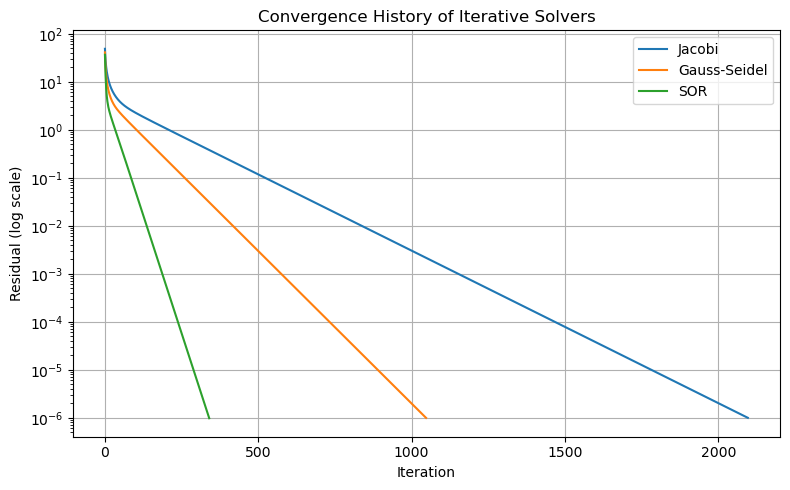

In [10]:
# Convergence history
plt.figure(figsize=(8, 5))
for name, res in residuals.items():
    if len(res) > 1:
        plt.semilogy(res, label=name)
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Convergence History of Iterative Solvers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

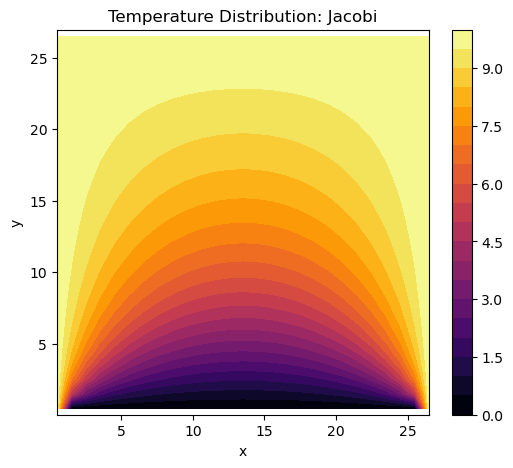

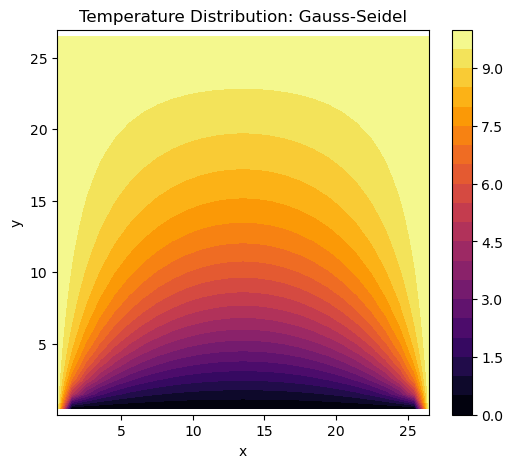

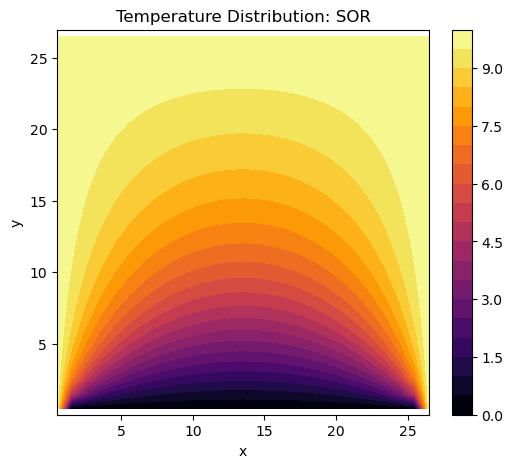

In [11]:
# Temperature distribution
for name, T_plot in tempretures.items():
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(T_plot, 20, cmap='inferno', origin='upper')
    plt.colorbar(cp)
    plt.title(f"Temperature Distribution: {name}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()